In [1]:
run __init__.py

In [2]:
import pandas as pd
from joblib import load, dump
from project import Project
from plot import Ploty
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from word2vec import make_model, class_weights_ohe, compute_aucs

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using TensorFlow backend.


In [ ]:
news_df = Project("2021-06-07", "2021-06-16", "AAPL", True, newsapi=True, finnhub=True, stocknews=True).run()

In [ ]:
news_df.to_csv('./data/news_all_api_07jun21-16jun21.csv', index=False)

In [ ]:
news_df.rename(columns={'sent':'sentiment','comp':'compound'}, inplace=True)

In [3]:
news_df = pd.read_csv('./data/news_all_api_07jun21-16jun21.csv')

In [4]:
news_df.head()

,date,source,url,articles,compound,sentiment
0,2021-06-16 13:33:44,Forbes,https://www.forbes.com/sites/jjkinahan/2021/06...,getty images key takeaways expect fed chairman...,0.9968,positive
1,2021-06-16 13:30:34,Yahoo Entertainment,https://finance.yahoo.com/news/3-historic-prec...,strong year technology nasdaq composite perfec...,0.9989,positive
2,2021-06-16 12:20:15,24/7 Wall St.,https://247wallst.com/technology-3/2021/06/16/...,even though personal health fitness long time ...,0.9896,positive
3,2021-06-16 10:37:25,Applech2.com,https://applech2.com/archives/20210616-macos-1...,aapl ch mac egpu macos big sur apple thunderbo...,0.8910,positive
4,2021-06-16 10:22:00,Motley Fool,https://www.fool.com/investing/2021/06/16/got-...,returns returns founded brothers tom david gar...,0.9982,positive


In [5]:
sentences = news_df['articles'].apply(lambda x: x.split()).to_list()

In [6]:
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(news_df['sentiment'].values.reshape(-1,1))

In [7]:
BIAS = class_weights_ohe(y_ohe)

In [8]:
max_lenght = 100
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(news_df['articles'])
sequences = tokenizer.texts_to_sequences(news_df['articles'])
word_index = tokenizer.word_index
# total vocabulary size plus 0 for unknown words
vocab_size = len(tokenizer.word_index) + 1
y_test = pad_sequences(sequences, max_lenght)

In [9]:
print(f"{'Unique Words':25} {len(tokenizer.index_word)}")
print(f"{'Shape of data tensor':25} {y_test.shape}")
print(f"{'Shape of label tensor':25} {y_ohe.shape}")

Unique Words              14118
Shape of data tensor      (465, 100)
Shape of label tensor     (465, 3)


In [10]:
model = keras.models.load_model('./model/model2.h5', compile=False)

In [11]:
model.compile(
            optimizer=keras.optimizers.adam(),
            loss=keras.losses.categorical_crossentropy,
            metrics=[keras.metrics.AUC()]
)

In [12]:
score = model.evaluate(y_test, y_ohe, steps=y_test.shape[0], workers=8, verbose=1)

465/465 [==============================] - 187s 403ms/step


## Computer AUC Accuracy

In [13]:
y_pred = model.predict(y_test, batch_size=1,verbose=1)

465/465 [==============================] - 21s 45ms/step


In [14]:
classes_accurasy = compute_aucs(y_pred, y_ohe)

In [15]:
model_stat_df = pd.DataFrame({"accuracy":classes_accurasy, 'classes':ohe.categories_[0], 'bias':BIAS})

In [16]:
model_stat_df.to_csv('./all_news/all_news_prediction.csv', index=False)

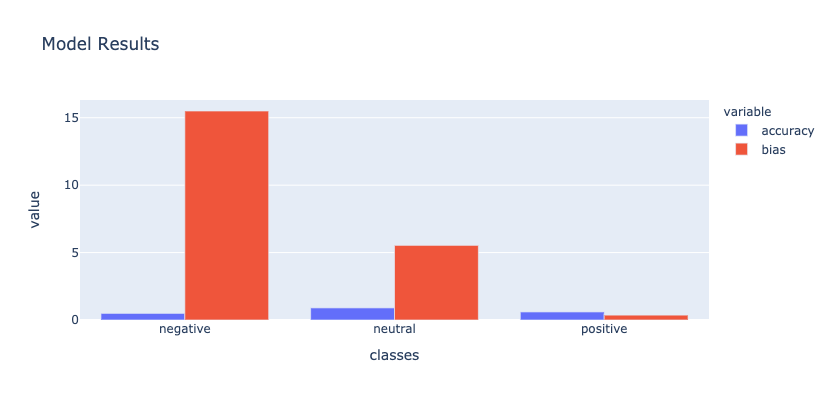

In [17]:
fig_cls = px.bar(model_stat_df,
                 x='classes',
                 y=['accuracy', 'bias'],
                 labels={'x': 'Class Name', 'y':'Accuracy'},
                 width=500,
                 height=400,
                 title='Model Results',
                 barmode='group',
                )
fig_cls.show()

In [18]:
plot_model = Ploty()

In [19]:
print('Accuracy :', score[1])

Accuracy : 344.6827644109726


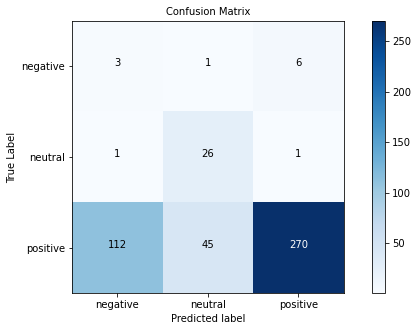

In [20]:
plot_model.confusion_matrix(y_true=y_ohe, y_pred=y_pred, target_name=ohe.categories_[0], file_name='./all_news/all_news_cm.jpg')

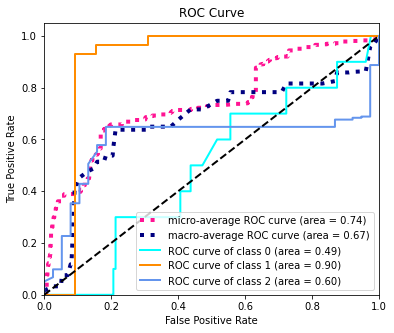

In [21]:
plot_model.plot_roc_curve(y_true=y_ohe, y_pred=y_pred, file_name='./all_news/all_news_roc.jpg')

In [22]:
dump(BIAS, './all_news/bias.pkl')

['./all_news/bias.pkl']

In [23]:
dump(y_ohe, './all_news/y_ohe.pkl')

['./all_news/y_ohe.pkl']

In [24]:
dump(y_ohe, './all_news/y_test.pkl')

['./all_news/y_test.pkl']

In [25]:
dump(y_ohe, './all_news/y_pred.pkl')

['./all_news/y_pred.pkl']